# Creating a custom node

Welcome to the `RxInfer` documentation on creating custom factor graph nodes. In `RxInfer`, nodes represent distributions, and a variety of distributions are supported natively. However, in some cases, you may need to create a custom node that better fits the specific requirements of your model. This tutorial will guide you through the process of defining a custom node in RxInfer, step by step. By the end of this tutorial, you'll be able to create your own custom node and integrate it into your model.

To create a custom node in `RxInfer`, 4 steps are required:

- Notify `RxInfer` of the nodes existence with the `@node` macro.
- Define update rules for sum-product message passing with the `@rule` macro. If needed, Variational Message Passing (VMP) rules can also be created with the `@rule` macro.
- Specify computations for marginal distributions of the relevant variables with the `@marginalrule` macro.
- Implement the computation of the Free Energy in a node with the `@average_energy` macro.

As an example, we will be recreating the node for the `Bernoulli` distribution. The `Bernoulli` distribution is a commonly used distribution in statistical modeling that represents a binary outcome, such as a coin flip. By recreating this node, we will be able to demonstrate the process of creating a custom node, from notifying `RxInfer` of the nodes existence to implementing the required methods. While this tutorial focuses on the `Bernoulli` distribution, the principles can be applied to creating custom nodes for other distributions as well. So let's get started!

## Defining the custom node

To begin creating a custom node, we first need to inform `RxInfer` that the new node exists. This is accomplished with the `@node` macro, which is exported by `RxInfer` and requires three arguments:

- The name of the node, which should be a `Type`. In this tutorial, we'll define a placeholder struct called `MyBernoulli` to serve as the name of our node.
- Whether the node is deterministic or stochastic. While most nodes in `RxInfer` are stochastic since they represent a distribution, it's also possible to define nodes for deterministic operations. Examples of deterministic nodes in `RxInfer` include the sum operation node and the product operation node.
- The interfaces of the node and any potential aliases. The interfaces are defined as the set of variables that a node operates on. For example, for the `Normal` distribution, this would be `[out, μ, σ]`. For our `MyBernoulli` distribution, we have the `out` and `p` interfaces. Since the `p` parameter is sometimes denoted as `θ`, we can add `θ` as an alias to the `p` parameter.

To get started, we'll import `RxInfer`, create the `MyBernoulli` `struct`, and call `@node` with the required parameters. We also implement the `mean` function for the `MyBernoulli` struct, as it is required in the update computations.

In [1]:
using RxInfer

struct MyBernoulli 
    p :: Real
end

Distributions.mean(d::MyBernoulli) = d.p

@node MyBernoulli Stochastic [out, (p, aliases = [θ])] 

## Defining rules for our node

In order to use our custom node, we should tell `RxInfer` how to send messages. The operation that transforms incoming messages into outgoing messages is called an update rule, and can be specified with the `@rule` macro. Here, we rely on conjugate computations. This is how `RxInfer` achieves high performance; by applying conjugate update rules where possible we are able to significantly speed up inference. We should define, for all interfaces, the conjugate computations that update the interface. We will start with the `out` interface. We know that the `out` interface should be `MyBernoulli` distributed. There are two possibilities of the distribution of the `p` parameter: A `Beta` distribution (the conjugate prior to the `Bernoulli` distribution) or a `PointMass` distribution (if the parameter `p`) is known. 

For the case of a `Beta` message coming into our node, the outgoing message will be the predictive posterior of the `Bernoulli` distribution with a `Beta` prior. Here we obtain $ p = \frac{\alpha}{\alpha + \beta}$, which coincides with the mean of the `Beta` distribution. Hence, we have our first update rule:

In [2]:
@rule MyBernoulli(:out, Marginalisation) (m_p :: Beta,) = MyBernoulli(mean(m_p))

Here, `m_p` is shorthand for "the sum-product message with input message for interface `p`". As we will see later, the VMP update rule for incoming message from `p` will have `q_p` as parameter, which is shorthand for the structural approximation rule when we assume independence between `p` and `out`. 

The second rule is also straightforward; if `p` is known the outgoing message will be `MyBernoulli(p)`:

In [3]:
@rule MyBernoulli(:out, Marginalisation) (m_p :: PointMass,) = MyBernoulli(mean(m_p))

Continuing with the sum-product update rules, we now have to define the update rules towards the `p` interface. We can only do exact inference if the incoming message is known, which in the case of the `Bernoulli` distribution, means that the `out` message is a `PointMass` distribution that is either `0` or `1`. The updated Beta distribution for `p` will be:
$$ p \sim Beta(1 + out, 2 - out)$$
Which gives us the following update rule:

In [4]:
@rule MyBernoulli(:p, Marginalisation) (m_out :: PointMass,) = begin
    p = mean(m_out)
    Beta(one(p) + p, 2one(p) - p)
end

The Variational Message Passing update for a PointMass input is quite similar. We will not derive variational update rules here. Interested readers can read more about Variational Message Passing [here](http://www.dauwels.com/files/VMP.pdf). The remaining variational update rules are as follows. Note that we are able to support a wider range of distributions as we are no longer constrained to conjugate computations, hence we can handle an incoming 

In [5]:
#rules towards out

@rule Bernoulli(:out, Marginalisation) (q_p::PointMass,) = Bernoulli(mean(q_p))

@rule Bernoulli(:out, Marginalisation) (q_p::Beta,) = Bernoulli(mean(q_p))

#rules towards p
@rule MyBernoulli(:p, Marginalisation) (q_out :: PointMass,) = begin
    p = mean(q_out)
    Beta(one(p) + p, 2one(p) - p)
end


@rule MyBernoulli(:p, Marginalisation) (q_out::MyBernoulli,) = begin
    p = mean(q_out)
    return Beta(one(p) + p, 2one(p) - p)
end

@rule Bernoulli(:p, Marginalisation) (q_out::Categorical,) = begin
    p = probvec(q_out)
    @assert length(p) == 2 "MyBernoulli is only defined over its support {0,1}. It has received a Categorical message that does not have 2 categories."
    r = p[2]
    return Beta(one(r) + r, 2one(r) - r)
end

## Defining marginals for our node

To calculate the updated posterior marginal for our custom distribution, we need to provide the posterior marginals for the interfaces of our node in a `NamedTuple`. In our case, the posterior marginal for the observation is still the same `PointMass` distribution. However, to calculate the posterior marginal over `p`, we use `RxInfer`'s built-in `prod` functionality to multiply the `Beta` prior with the `Beta` likelihood. This gives us the updated posterior distribution, which is also a `Beta` distribution. We use `ProdAnalytical()` parameter to ensure that we multiply the two distributions analytically. This is done as follows:

In [6]:
@marginalrule Bernoulli(:out_p) (m_out::PointMass, m_p::Beta) = begin
    r = mean(m_out)
    p = prod(ProdAnalytical(), Beta(one(r) + r, 2one(r) - r), m_p)
    return (out = m_out, p = p)
end

## Defining the average energy for our node

Free Energy Minimization is performed by `RxInfer` when exact posterior distributions cannot be derived, which is almost always the case except for full conjugacy. As a result, the calculation of the Free Energy in a node is crucial when constructing a node. The calculation of the Free Energy in nodes is critical in approximating the Free Energy in a model, which is the quantity we aim to minimize. However, this tutorial will not delve into the details of the actual Free Energy calculation.

In [7]:
@average_energy Bernoulli (q_out::Any, q_p::Any) = -mean(q_out) * mean(log, q_p) - (1.0 - mean(q_out)) * mean(mirrorlog, q_p)

## Using our node in a model

We have now defined all required functions in order to test our node in an experiment. In this experiment, we will generate a dataset drawn from a Bernoulli distribution, where the probability of success is fixed at 0.75. We will then define a probabilistic model that has a `Beta` prior and a `MyBernoulli` likelihood. First we generate the dataset:

In [8]:
using Random

rng = MersenneTwister(42)
n = 500
p_real = 0.75
distribution = Bernoulli(p_real)

dataset = float.(rand(rng, distribution, n));

Next, we define our model, note that we use the `MyBernoulli` node in the model.

In [9]:
@model function coin_model_mybernoulli(n)

    # `datavar` creates data 'inputs' in our model
    y = datavar(Float64, n)

    # We endow θ parameter of our model with some prior
    p ~ Beta(4.0, 8.0)

    # We assume that outcome of each coin flip is governed by the MyBernoulli distribution
    for i in 1:n
        y[i] ~ MyBernoulli(p)
    end

end

Finally, we can run inference with this model and the generated dataset:

In [10]:
result_mybernoulli = inference(
    model = coin_model_mybernoulli(length(dataset)), 
    data  = (y = dataset, ),
)

Inference results:
  Posteriors       | available for (p)


We can see that the posterior distribution for p is available. Let's see if our posterior distribution is close to the true parameter:

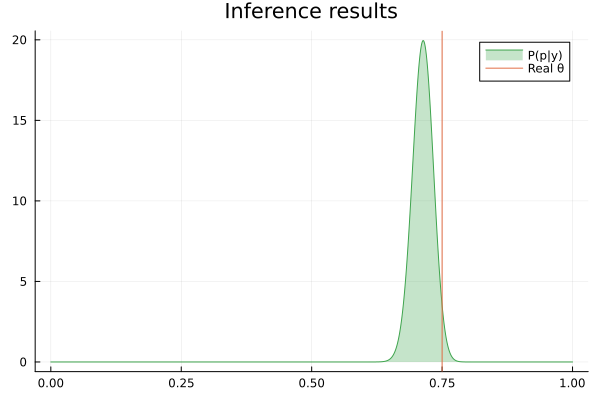

In [11]:
using Plots

rθ = range(0, 1, length = 1000)

p = plot(title = "Inference results")

plot!(rθ, (x) -> pdf(result_mybernoulli.posteriors[:p], x), fillalpha=0.3, fillrange = 0, label="P(p|y)", c=3)
vline!([p_real], label="Real θ")

As a sanity check, we can create the same model with the `RxInfer` builtin node `Bernoulli`. This should give us the same posterior distributions:

In [12]:
@model function coin_model(n)
    
    y = datavar(Float64, n)
    p ~ Beta(4.0, 8.0)

    for i in 1:n
        y[i] ~ Bernoulli(p)
    end

end
result_bernoulli = inference(
    model = coin_model(length(dataset)), 
    data  = (y = dataset, ),
)
println(result_bernoulli.posteriors[:p] == result_mybernoulli.posteriors[:p])

true


Congratulations! You have succesfully implemented your own custom node in `RxInfer`. We went through the definition of a node to the implementation of the update rules and marginal posterior calculations. Finally we tested our custom node in a model and checked if we implemented everything correctly.